In [2]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from resource import getrusage, RUSAGE_SELF
from cohirf.experiment.tested_models import models_dict
import pickle
from pathlib import Path
import gc
import matplotlib.pyplot as plt
from time import perf_counter

In [3]:
models_dict.keys()

dict_keys(['CoHiRF', 'CoHiRF-DBSCAN', 'Clique', 'IRFLLRR', 'KMeansProj', 'Proclus', 'SpectralSubspaceRandomization', 'KMeans', 'OPTICS', 'DBSCAN', 'SpectralClustering', 'MeanShift', 'AffinityPropagation', 'HDBSCAN', 'WardAgglomerativeClustering', 'CompleteAgglomerativeClustering', 'AverageAgglomerativeClustering', 'SingleAgglomerativeClustering'])

In [4]:
results_path = Path("/home/users/belucci/cohirf/results/mem_test")

In [5]:
model_name = "CoHiRF"
model_cls, model_params, _, _ = models_dict[model_name]
# model_params["n_samples_representative"] = 1000
save_path = results_path / model_name
save_path.mkdir(parents=True, exist_ok=True)
memory_after_dataset = []
memory_after_model = []
fit_time = []
ns_samples = [int(1e3), int(1e4), int(1e5)]#, int(1e6), int(1e7), int(1e8), int(1e9)]
for i, n_samples in enumerate(ns_samples):
    print(f'Processing {n_samples:.1e} samples...')
    n_features = 3
    centers = 3
    X, y = make_blobs(
		n_samples=n_samples,
		n_features=n_features,
		centers=centers,
	)
    memory_after_dataset.append(getrusage(RUSAGE_SELF).ru_maxrss / 1024)  # Convert to MB
    model = model_cls(**model_params)
    print(f"Fitting with {n_samples:.1e} samples...")
    start_time = perf_counter()
    y_pred = model.fit_predict(X)
    elapsed_time = perf_counter() - start_time
    memory_after_model.append(getrusage(RUSAGE_SELF).ru_maxrss / 1024)  # Convert to MB
    fit_time.append(elapsed_time)
    # save results in case kernel crashes
    with open(save_path / "memory_usage.pkl", "wb") as f:
        pickle.dump(
            {
                "ns_samples": ns_samples[:i + 1],
                "memory_after_dataset": memory_after_dataset,
                "memory_after_model": memory_after_model,
                "fit_time": fit_time,
                "model_name": model_name,
            },
            f,
        )
    del X, y, y_pred, model  # Clear memory
    gc.collect()

Processing 1.0e+03 samples...
Fitting with 1.0e+03 samples...
Processing 1.0e+04 samples...
Fitting with 1.0e+04 samples...
Processing 1.0e+05 samples...
Fitting with 1.0e+05 samples...


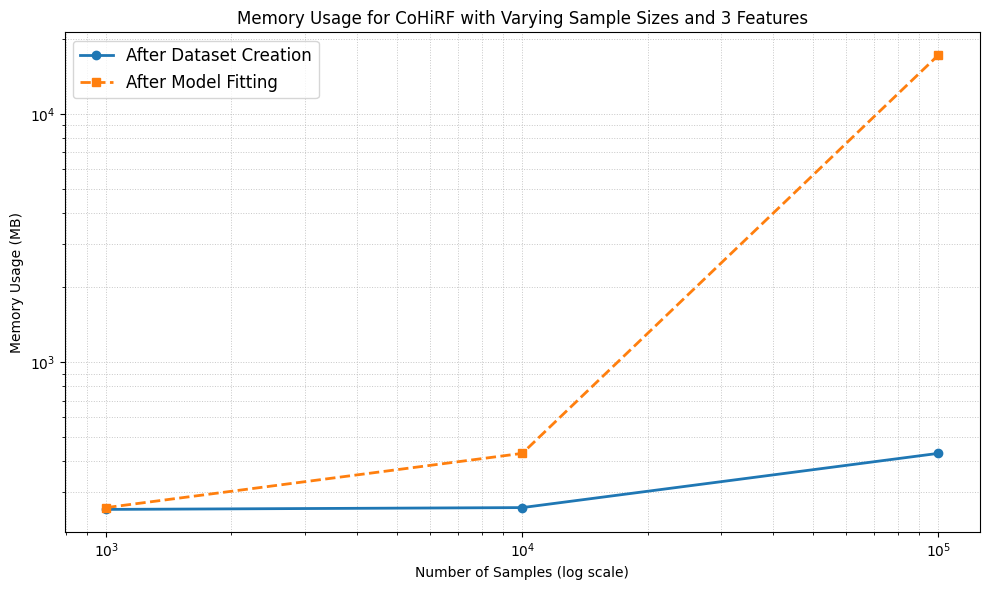

In [6]:
# Plotting memory usage
plt.figure(figsize=(10, 6))
plt.plot(
    ns_samples,
    memory_after_dataset,
    label="After Dataset Creation",
    marker="o",
    linestyle="-",
    linewidth=2,
    color="tab:blue",
)
plt.plot(
    ns_samples,
    memory_after_model,
    label="After Model Fitting",
    marker="s",
    linestyle="--",
    linewidth=2,
    color="tab:orange",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Memory Usage (MB)")
plt.title(f"Memory Usage for {model_name} with Varying Sample Sizes and {n_features} Features")
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, which="both", linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.savefig(save_path / "memory_usage_plot.png")

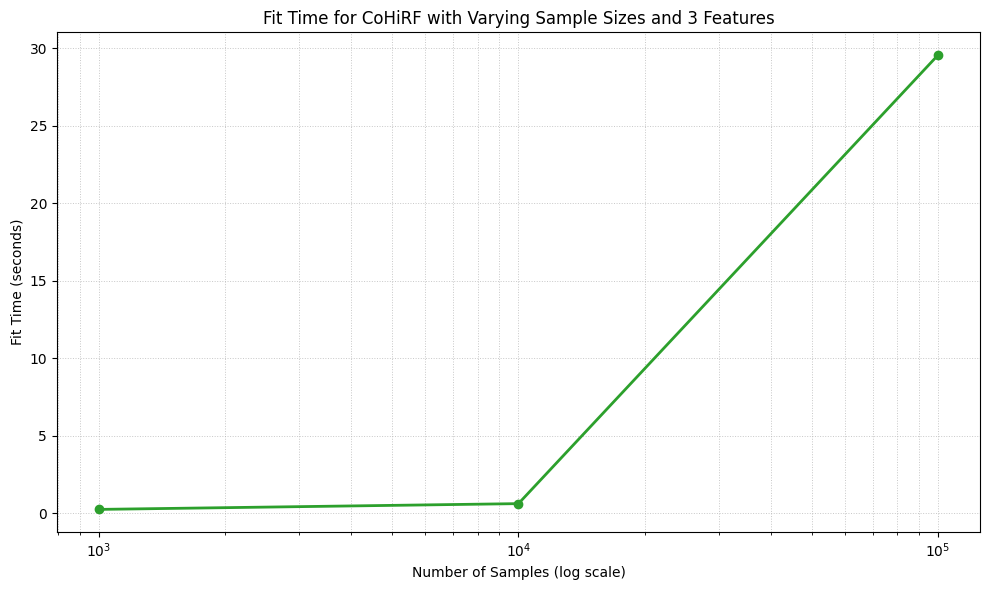

In [7]:
# Plotting fit time
plt.figure(figsize=(10, 6))
plt.plot(
	ns_samples,
	fit_time,
	marker="o",
	linestyle="-",
	linewidth=2,
	color="tab:green",
)
plt.xscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Fit Time (seconds)")
plt.title(f"Fit Time for {model_name} with Varying Sample Sizes and {n_features} Features")
plt.grid(True, which="both", linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.savefig(save_path / "fit_time_plot.png")


In [8]:
# Get memory and fit time for every model already saved
save_path = results_path
exp_results = {}
for dir in save_path.iterdir():
	if dir.is_dir() and (dir / "memory_usage.pkl").exists():
		with open(dir / "memory_usage.pkl", "rb") as f:
			results = pickle.load(f)
			exp_results[results["model_name"]] = {
				"n_samples": results["ns_samples"],
				"memory_after_dataset": results["memory_after_dataset"],
				"memory_after_model": results["memory_after_model"],
				"fit_time": results["fit_time"],
			}

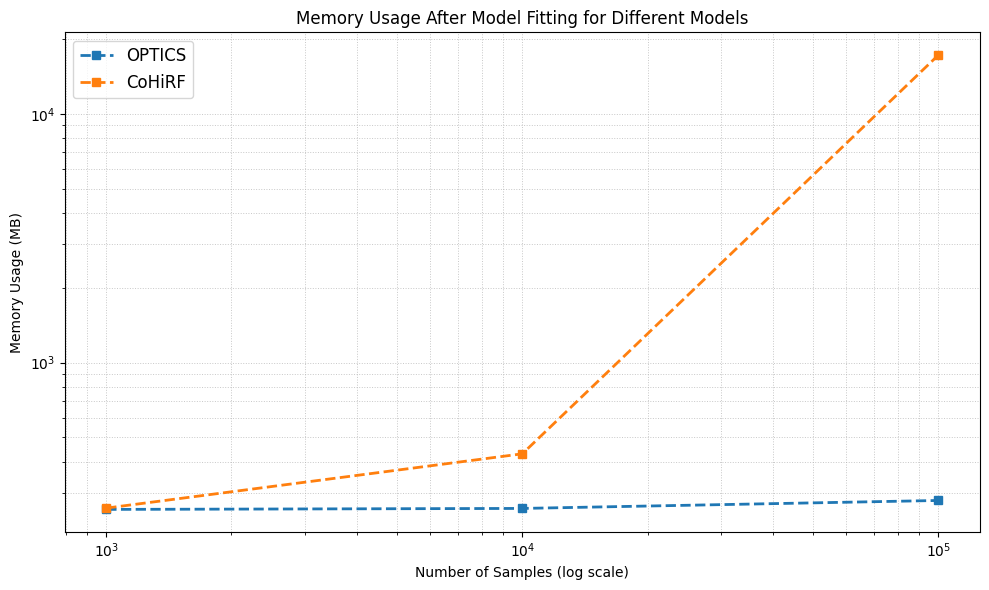

In [9]:
# plot all models together (memory)
plt.figure(figsize=(10, 6))
for model_name, results in exp_results.items():
	plt.plot(
		results["n_samples"],
		results["memory_after_model"],
		label=f"{model_name}",
		marker="s",
		linestyle="--",
		linewidth=2,
	)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage After Model Fitting for Different Models")
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, which="both", linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()

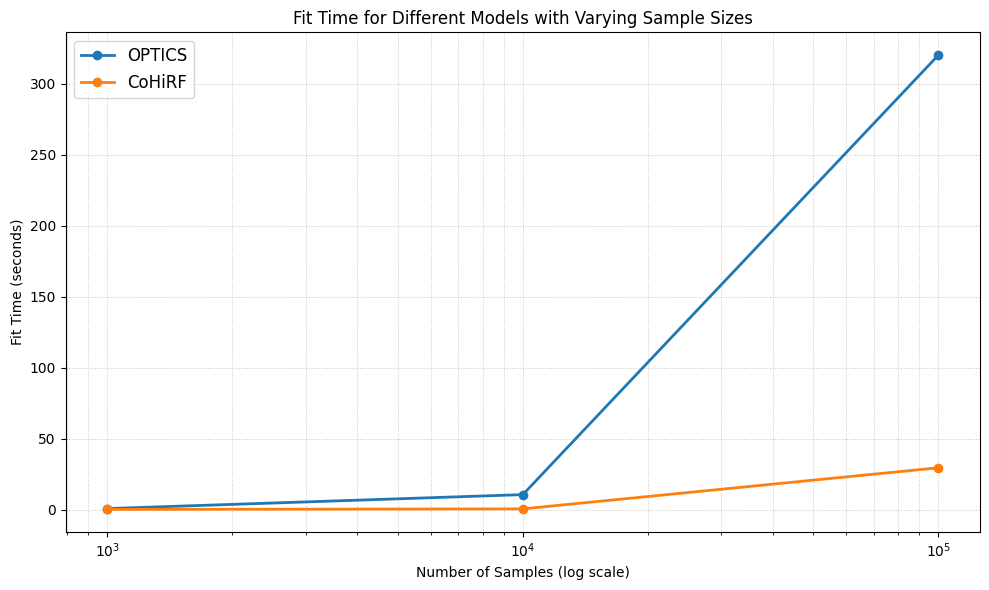

In [10]:
# plot all models together (fit time)
plt.figure(figsize=(10, 6))
for model_name, results in exp_results.items():
	plt.plot(
		results["n_samples"],
		results["fit_time"],
		label=f"{model_name}",
		marker="o",
		linestyle="-",
		linewidth=2,
	)
plt.xscale("log")
plt.xlabel("Number of Samples (log scale)")
plt.ylabel("Fit Time (seconds)")
plt.title("Fit Time for Different Models with Varying Sample Sizes")
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, which="both", linestyle=":", linewidth=0.7, alpha=0.7)
plt.tight_layout()